# Iteration 4

In [1]:
# Must be included at the beginning of each new notebook. Remember to change the app name.
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, stddev, col, randn, when, lit,sum, mean,row_number, rand, monotonically_increasing_id

from pyspark.sql.window import Window
spark = SparkSession.builder.appName('Iteration4').getOrCreate()

In [2]:
# load the data
df = spark.read.csv('./suicide/suicide_rates_1990-2022.csv', inferSchema=True, header=True)

# 2.Data Understanding

## 2.3 Data Exploration

In [ ]:
# describe data
df.printSchema()
print('Index:',df.count())
print('Data columns:',len(df.columns))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# caculate the sum of SuicideCount with same AgeGroup
gdp = df.groupBy("GDPPerCapita").agg(sum("SuicideCount").alias("Total_SuicideCount"))

# trans to Pandas DataFrame
pandas_df = gdp.toPandas()
pandas_df = pandas_df.sort_values(by="GDPPerCapita")

plt.figure(figsize=(10, 6))
plt.plot(pandas_df["GDPPerCapita"], pandas_df["Total_SuicideCount"], color='skyblue')
plt.xlabel('GDPPerCapita')
plt.ylabel('Total SuicideCount')
plt.title('Total SuicideCount by GDPPerCapita')
plt.show()

In [ ]:
age_group_counts = df.groupBy("AgeGroup").agg(count("*").alias("count"))

# trans to Pandas DataFrame
pandas_age_group_counts = age_group_counts.toPandas()
pandas_age_group_counts = pandas_age_group_counts.sort_values(by="AgeGroup")

# plot histogram
plt.figure(figsize=(12, 6))
plt.bar(pandas_age_group_counts["AgeGroup"], pandas_age_group_counts["count"], color='skyblue')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Age Group Distribution')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# caculate the sum of SuicideCount with same AgeGroup
aggregated_df = df.groupBy("AgeGroup").agg(sum("SuicideCount").alias("Total_SuicideCount"))

# trans to Pandas DataFrame
pandas_df = aggregated_df.toPandas()
pandas_df = pandas_df.sort_values(by="AgeGroup")

plt.figure(figsize=(10, 6))
plt.bar(pandas_df["AgeGroup"], pandas_df["Total_SuicideCount"], color='skyblue')
plt.xlabel('AgeGroup')
plt.ylabel('Total SuicideCount')
plt.title('Total SuicideCount by AgeGroup')
plt.show()

In [ ]:
# caculate the sum of SuicideCount with same AgeGroup
year = df.groupBy("Year").agg(sum("SuicideCount").alias("Total_SuicideCount"))

# trans to Pandas DataFrame
pandas_df = year.toPandas()
pandas_df = pandas_df.sort_values(by="Year")

plt.figure(figsize=(10, 6))
plt.plot(pandas_df["Year"], pandas_df["Total_SuicideCount"], color='skyblue')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xlabel('Year')
plt.ylabel('Total SuicideCount')
plt.title('Total SuicideCount by AgeGroup')
plt.show()

## 2.4 Verifying Data Quality

In [ ]:
df.show(10)

In [ ]:
# missing value
null_counts = df.select([sum(col(column).isNull().cast("int")).alias(column) for column in df.columns])
null_counts.show()

In [ ]:
round(df.dropna().count() / df.count() * 100, 2)

# 3.Data Preparation
## 3.1 Data selection

In [4]:
df_drop = df.drop('RegionCode', 'CountryCode', 'Generation', 'CauseSpecificDeathPercentage')

df_drop.show(10)

+----------+-----------+----+----+-----------+------------+----------------+----------+-------------+------------+-------------------+------------+-------------+-------------------------+
|RegionName|CountryName|Year| Sex|   AgeGroup|SuicideCount|DeathRatePer100K|Population|          GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|
+----------+-----------+----+----+-----------+------------+----------------+----------+-------------+------------+-------------------+------------+-------------+-------------------------+
|    Europe|    Albania|1992|Male| 0-14 years|           0|             0.0|   3247039|6.521749908E8| 200.8522198|      9.061842123E8|        1740|  226.0054213|                   45.315|
|    Europe|    Albania|1992|Male| 0-14 years|           0|             0.0|   3247039|6.521749908E8| 200.8522198|      9.061842123E8|        1740|  226.0054213|                   45.315|
|    Europe|    Albania|1992|Male| 0-14 years|           0| 

In [ ]:
df_drop.printSchema()

## 3.2 Clean Data

### Null value

In [ ]:
null_counts = df_drop.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_drop.columns])
null_counts.show()

In [5]:
# fill null value for SuicideCount and Population
mean_values = df_drop.select(mean("SuicideCount").alias("mean_SuicideCount"), mean("Population").alias("mean_Population")).collect()[0]

df_drop = df_drop.na.fill({"SuicideCount": mean_values[0], "Population": mean_values[1]})

In [6]:
# use the normal distribution to randomly fill
# caculate mean and stand dev
stats = df_drop.select(
    [avg(c).alias(f"mean_{c}") for c in df_drop.columns] +
    [stddev(c).alias(f"stddev_{c}") for c in df_drop.columns]
).collect()[0]


mean_stddev_dict = {col: (stats[f"mean_{col}"], stats[f"stddev_{col}"]) for col in df_drop.columns}

# fill null value in each column
for col_name in df_drop.columns:
    mean = mean_stddev_dict[col_name][0]
    stddev = mean_stddev_dict[col_name][1]
    
    # normal distribution
    random_col = randn() * stddev + mean
    df_drop = df_drop.withColumn(
        col_name,
        when(col(col_name).isNull(), random_col).otherwise(col(col_name))
    )



24/05/23 07:34:03 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [ ]:
null_counts = df_drop.select([sum(col(column).isNull().cast("int")).alias(column) for column in df_drop.columns])
null_counts.show()

### Extrem value

In [ ]:
df_drop.select('GDP').describe().show()

In [ ]:
df_drop.filter(df_drop['GDP']<0).count()

In [7]:
df_drop = df_drop.filter(df_drop['GDP']>=0)

# check again
df_drop.select('GDP').describe().show()

+-------+--------------------+
|summary|                 GDP|
+-------+--------------------+
|  count|              115839|
|   mean|5.279130417829601...|
| stddev|1.646626698464828...|
|    min|        2.19762963E8|
|    max|          2.33151E13|
+-------+--------------------+



## 3.3 Constructing/Deriving a New Feature and Data Integration

In [8]:
aggregated_df = df_drop.groupBy("RegionName", "Year", "Sex", "AgeGroup", "Population", 
                           "GDP", "GDPPerCapita", "GrossNationalIncome", "GNIPerCapita", 
                           "InflationRate", "EmploymentPopulationRatio").agg(
    sum("SuicideCount").alias("SuicideCount"),
    avg("DeathRatePer100K").alias("DeathRatePer100K")
)
aggregated_df.show(10)

+--------------------+------+------+-----------+-----------+---------------+------------+-------------------+------------+-----------------+-------------------------+------------+------------------+
|          RegionName|  Year|   Sex|   AgeGroup| Population|            GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|    InflationRate|EmploymentPopulationRatio|SuicideCount|  DeathRatePer100K|
+--------------------+------+------+-----------+-----------+---------------+------------+-------------------+------------+-----------------+-------------------------+------------+------------------+
|              Europe|2008.0|  Male|    Unknown|  2947314.0|1.2881352894E10| 4370.539716|    1.1892990139E10|      8270.0|      3.320870904|                   46.243|         0.0| 18.34606233273754|
|Central and South...|2010.0|Female|  75+ years|4.0788453E7|     4.23627E11| 10385.96443|         3.78241E11|     17450.0|28.99244671928664|                   55.549|        16.0|        3.21878483|
|    

In [ ]:
print('Index:',aggregated_df.count())
null_counts = aggregated_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in aggregated_df.columns])
null_counts.show()

## 3.4.Data Integration

In [9]:
df1, df2 = aggregated_df.randomSplit([0.5, 0.5])

In [ ]:
print('Index of df1:',df1.count())
print('Data columns of df1:',len(df1.columns))

print('Index of df2:',df2.count())
print('Data columns of df2:',len(df2.columns))

In [50]:
merged_df = df1.union(df2)

merged_df.describe().show()

null_counts = merged_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in merged_df.columns])
null_counts.show()

+-------+----------+-----------------+-------+----------+--------------------+--------------------+------------------+--------------------+------------------+------------------+-------------------------+------------------+------------------+
|summary|RegionName|             Year|    Sex|  AgeGroup|          Population|                 GDP|      GDPPerCapita| GrossNationalIncome|      GNIPerCapita|     InflationRate|EmploymentPopulationRatio|      SuicideCount|  DeathRatePer100K|
+-------+----------+-----------------+-------+----------+--------------------+--------------------+------------------+--------------------+------------------+------------------+-------------------------+------------------+------------------+
|  count|     53816|            53816|  53816|     53816|               53816|               53816|             53816|               53816|             53816|             53816|                    53816|             53816|             53816|
|   mean|      null|2004.9114947

+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|RegionName|Year|Sex|AgeGroup|Population|GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|SuicideCount|DeathRatePer100K|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|         0|   0|  0|       0|         0|  0|           0|                  0|           0|            0|                        0|           0|               0|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+



In [ ]:
merged_df.show(10)

In [ ]:
merged_df.printSchema()

merged_df = merged_df.withColumn("SuicideCount", col("SuicideCount").cast("int"))
# after modify
merged_df.printSchema()

In [ ]:
merged_df.groupBy("Sex").count().show()

In [51]:
df_with_id = merged_df.withColumn("ID", monotonically_increasing_id())

unknown_count = df_with_id.filter(df_with_id["Sex"] == "Unknown").count()

window_spec = Window.orderBy("ID")
df_with_index = df_with_id.withColumn("index", row_number().over(window_spec))

half_count = unknown_count // 2
merged_df = df_with_index.withColumn(
    "Sex",
    when(
        (col("Sex") == "Unknown") & (col("index") <= half_count),
        "Male"
    ).when(
        (col("Sex") == "Unknown") & (col("index") > half_count),
        "Female"
    ).otherwise(col("Sex"))
).drop("ID").drop("index")


In [ ]:
merged_df.groupBy("Sex").count().show()

In [ ]:
merged_df.printSchema()

# 4. Data Transformation


In [13]:
from pyspark.sql.functions import log1p
import seaborn as sns
import pandas as pd

In [ ]:
# calculate SuicideCount correlation
colum = ['Year', 'Population', 
    'GDP', 'GDPPerCapita', 'GrossNationalIncome', 'GNIPerCapita', 
    'InflationRate', 'EmploymentPopulationRatio']

target_column = 'SuicideCount'
correlations = {column: merged_df.stat.corr(column, target_column) for column in colum}


sorted_correlations = pd.Series(correlations).sort_values(ascending=False)

# result
print(sorted_correlations)

## 4.2 Data Projection

In [ ]:
population_data = merged_df.select("Population").rdd.flatMap(lambda x: x).collect()

# Population hist plot
sns.histplot(population_data, bins=10, kde=True, color='green')
plt.xlabel('Population')

In [ ]:
sns.histplot(merged_df.select("GDP").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GDP')

In [ ]:
sns.histplot(merged_df.select("SuicideCount").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('SuicideCount')

In [ ]:
sns.histplot(merged_df.select("GNIPerCapita").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GNIPerCapita')

In [ ]:
sns.histplot(merged_df.select("GrossNationalIncome").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GrossNationalIncome')

In [ ]:
sns.histplot(merged_df.select("EmploymentPopulationRatio").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('EmploymentPopulationRatio')

In [ ]:
sns.histplot(merged_df.select("DeathRatePer100K").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('DeathRatePer100K')

In [ ]:
sns.histplot(merged_df.select("GDPPerCapita").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('GDPPerCapita')

In [ ]:
sns.histplot(merged_df.select("InflationRate").rdd.flatMap(lambda x: x).collect(), bins=10, kde=True, color='green')
plt.xlabel('InflationRate')

In [14]:
columns_to_transform = ['Population', 'SuicideCount', 'GDP', 'DeathRatePer100K',
                        'GrossNationalIncome', 'GNIPerCapita', 'EmploymentPopulationRatio', 'GDPPerCapita','InflationRate']

for column in columns_to_transform:
    merged_df = merged_df.withColumn(column, log1p(col(column)))



In [ ]:
for column in columns_to_transform:
    plt.figure()
    column_data = merged_df.select(column).rdd.flatMap(lambda x: x).collect()
    # plot histogram
    sns.histplot(column_data, bins=10, kde=True, color='green')
    plt.title(f'Histogram of {column}')
    plt.xlabel(f'log_{column}')
    plt.show()

In [ ]:
merged_df.printSchema()

# 6.Data-Mining Algorithm(s) Selection
## 6.3. Build/Select Model with Algorithm/Model Parameter(s)

In [15]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

In [ ]:
null_counts = merged_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in merged_df.columns])
null_counts.show()

In [16]:
merged_df = merged_df.na.drop()
null_counts = merged_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in merged_df.columns])
null_counts.show()

24/05/23 07:35:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 07:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 07:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 07:35:57 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|RegionName|Year|Sex|AgeGroup|Population|GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|SuicideCount|DeathRatePer100K|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|         0|   0|  0|       0|         0|  0|           0|                  0|           0|            0|                        0|           0|               0|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+



In [33]:
merged_df.columns

['RegionName',
 'Year',
 'Sex',
 'AgeGroup',
 'Population',
 'GDP',
 'GDPPerCapita',
 'GrossNationalIncome',
 'GNIPerCapita',
 'InflationRate',
 'EmploymentPopulationRatio',
 'SuicideCount',
 'DeathRatePer100K']

In [34]:
string_columns = ['RegionName', 'Sex', 'AgeGroup']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in string_columns]

feature_columns = ['Year', 'Population', 'GDP', 'GDPPerCapita', 'GrossNationalIncome', 
                   'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio', 'DeathRatePer100K'] + \
                   [f"{col}_indexed" for col in string_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# use Pipeline
pipeline = Pipeline(stages=indexers + [assembler])
df_prepared = pipeline.fit(merged_df).transform(merged_df)

24/05/23 08:10:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

In [35]:
train_df, test_df = df_prepared.randomSplit([0.7, 0.3], seed=42)

In [24]:
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [36]:
rf = RandomForestRegressor(labelCol="SuicideCount", featuresCol="features", numTrees=100)

# training model
rf_model = rf.fit(train_df)

24/05/23 08:10:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:48 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:49 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:10:50 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [37]:
# performance on training data
fit = rf_model.transform(train_df)

# evaluate
evaluator_rmse = RegressionEvaluator(labelCol="SuicideCount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(fit)
evaluator_r2 = RegressionEvaluator(labelCol="SuicideCount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(fit)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R-squared on test data = {r2}")

24/05/23 08:11:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:10 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:12 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:13 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:14 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

Root Mean Squared Error (RMSE) on test data = 1.0254153508680108
R-squared on test data = 0.7961738688222975


In [38]:
# predict on test set
predictions = rf_model.transform(test_df)

# evaluate
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

print(f"R-squared on test data = {r2}")

24/05/23 08:11:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 08:11:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

Root Mean Squared Error (RMSE) on test data = 1.0209705364379418
R-squared on test data = 0.7974086113583381


In [39]:
# capture the feature importance
importances = rf_model.featureImportances

feature_importances = [(feature, importance) for feature, importance in zip(feature_columns, importances)]

# sort the importance
sorted_feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_feature_importances:
    print(f"Feature: {feature}, Importance: {importance:.6f}")

Feature: DeathRatePer100K, Importance: 0.315749
Feature: AgeGroup_indexed, Importance: 0.226829
Feature: Population, Importance: 0.216074
Feature: GrossNationalIncome, Importance: 0.085314
Feature: GDP, Importance: 0.081701
Feature: RegionName_indexed, Importance: 0.035339
Feature: Sex_indexed, Importance: 0.017346
Feature: InflationRate, Importance: 0.008806
Feature: GDPPerCapita, Importance: 0.006722
Feature: GNIPerCapita, Importance: 0.003689
Feature: EmploymentPopulationRatio, Importance: 0.002112
Feature: Year, Importance: 0.000318


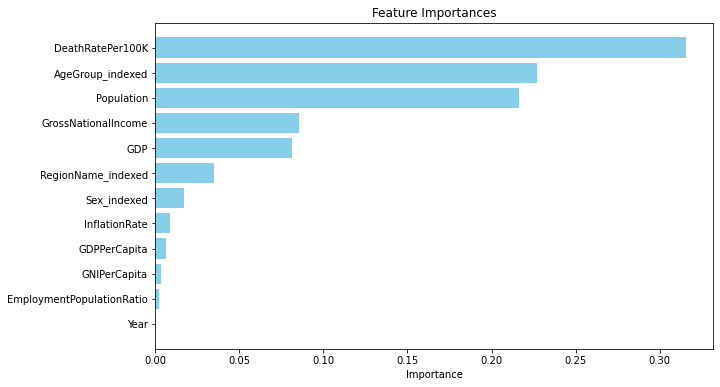

In [40]:
features, importances = zip(*sorted_feature_importances)

plt.figure(figsize=(10, 6))
plt.barh(features, importances, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # invert the Y-axis so that the most important features are at the top
plt.show()

# 8. Interpretation

In [41]:
from pyspark.sql.functions import corr

In [45]:
#  check the Pearson correlation coefficien
correlation_PS = merged_df.select(corr('Population', 'SuicideCount')).collect()[0][0]
correlation_DS = merged_df.select(corr('DeathRatePer100K', 'SuicideCount')).collect()[0][0]

print(f"Pearson correlation coefficient between Population and SuicideCount is {correlation_PS}")
print(f"Pearson correlation coefficient between DeathRatePer100K and SuicideCount is {correlation_DS}")

24/05/23 09:26:29 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:26:30 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:26:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:26:31 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:26:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 09:26:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 0

Pearson correlation coefficient between Population and SuicideCount is 0.5804450914867084
Pearson correlation coefficient between DeathRatePer100K and SuicideCount is 0.4880105967450528


## Visualising the Data,Results,Models and Patterns 

In [ ]:
from pyspark.ml.regression import LinearRegression

# visual DeathRatePer100K vs. SuicideCount
assembler = VectorAssembler(inputCols=['DeathRatePer100K'], outputCol='features')
df_vectorized = assembler.transform(merged_df)

# fit a linear regression model
lr = LinearRegression(featuresCol='features', labelCol='SuicideCount')
lr_model = lr.fit(df_vectorized)

# prediction
predictions = lr_model.transform(df_vectorized)
predictions_pd = predictions.select('DeathRatePer100K', 'SuicideCount', 'prediction').toPandas()


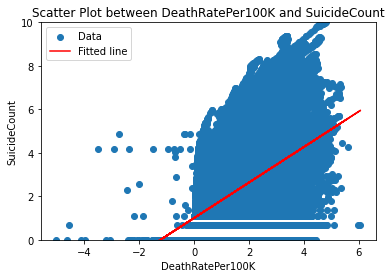

In [47]:
# plot scatter plot
plt.scatter(predictions_pd['DeathRatePer100K'], predictions_pd['SuicideCount'], label='Data')
plt.plot(predictions_pd['DeathRatePer100K'], predictions_pd['prediction'], color='red', label='Fitted line')
plt.title('Scatter Plot between DeathRatePer100K and SuicideCount')
plt.xlabel('DeathRatePer100K')
plt.ylabel('SuicideCount')
plt.ylim(0, 10)
plt.legend()
plt.show()

In [ ]:
# visual Population vs. SuicideCount
assembler = VectorAssembler(inputCols=['Population'], outputCol='features')
df_vectorized = assembler.transform(merged_df)

# fit a linear regression model
lr = LinearRegression(featuresCol='features', labelCol='SuicideCount')
lr_model = lr.fit(df_vectorized)

# prediction
predictions = lr_model.transform(df_vectorized)
predictions_pd = predictions.select('Population', 'SuicideCount', 'prediction').toPandas()

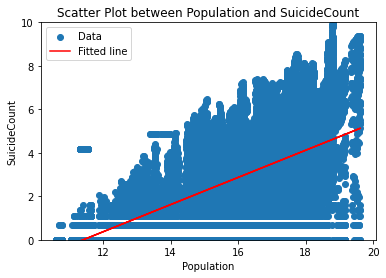

In [49]:
# plot scatter plot
plt.scatter(predictions_pd['Population'], predictions_pd['SuicideCount'], label='Data')
plt.plot(predictions_pd['Population'], predictions_pd['prediction'], color='red', label='Fitted line')
plt.title('Scatter Plot between Population and SuicideCount')
plt.xlabel('Population')
plt.ylabel('SuicideCount')
plt.ylim(0, 10)
plt.legend()
plt.show()

### Iterations

In [52]:
from pyspark.sql.functions import pow

In [55]:
columns_to_transform = ['Population', 'SuicideCount', 'GDP', 'DeathRatePer100K',
                        'GrossNationalIncome', 'GNIPerCapita', 'EmploymentPopulationRatio', 'GDPPerCapita','InflationRate']

for column in columns_to_transform:
    merged_df = merged_df.withColumn(column, log1p(pow(col(column),2)))

In [56]:
null_counts = merged_df.select([sum(col(column).isNull().cast("int")).alias(column) for column in merged_df.columns])
null_counts.show()

24/05/23 10:10:52 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:10:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:10:53 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:10:54 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|RegionName|Year|Sex|AgeGroup|Population|GDP|GDPPerCapita|GrossNationalIncome|GNIPerCapita|InflationRate|EmploymentPopulationRatio|SuicideCount|DeathRatePer100K|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+
|         0|   0|  0|       0|         0|  0|           0|                  0|           0|            0|                        0|           0|               0|
+----------+----+---+--------+----------+---+------------+-------------------+------------+-------------+-------------------------+------------+----------------+



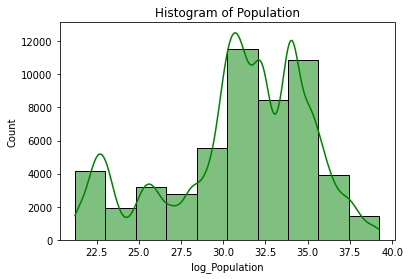

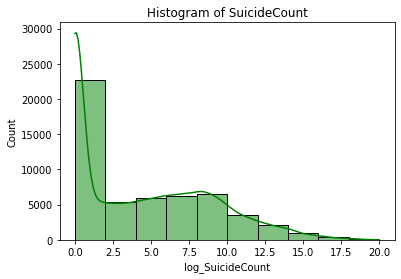

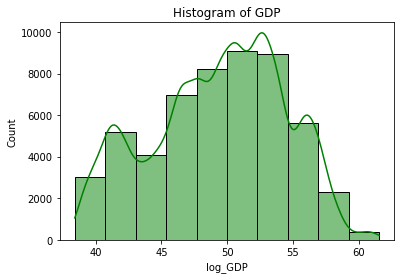

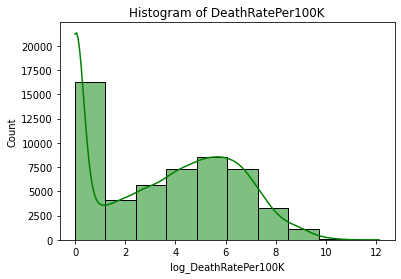

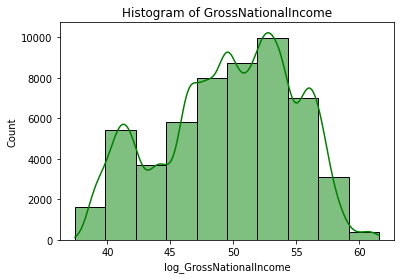

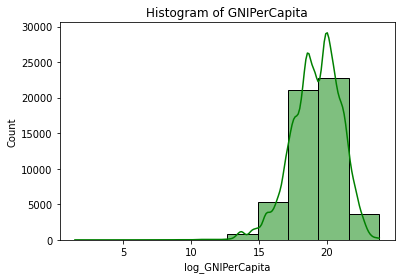

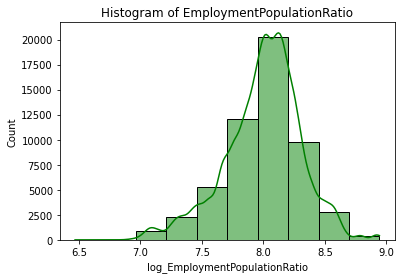

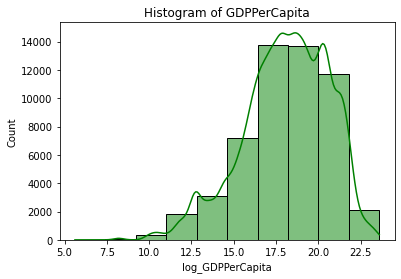

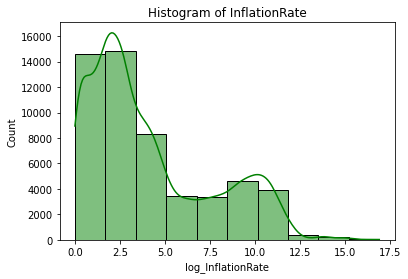

In [59]:
for column in columns_to_transform:
    plt.figure()
    column_data = merged_df.select(column).rdd.flatMap(lambda x: x).collect()
    # plot histogram
    sns.histplot(column_data, bins=10, kde=True, color='green')
    plt.title(f'Histogram of {column}')
    plt.xlabel(f'log_{column}')
    plt.show()

In [57]:
string_columns = ['RegionName', 'Sex', 'AgeGroup']
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_indexed") for col in string_columns]

feature_columns = ['Year', 'Population', 'GDP', 'GDPPerCapita', 'GrossNationalIncome', 
                   'GNIPerCapita', 'InflationRate', 'EmploymentPopulationRatio', 'DeathRatePer100K'] + \
                   [f"{col}_indexed" for col in string_columns]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# use Pipeline
pipeline = Pipeline(stages=indexers + [assembler])
df_prepared = pipeline.fit(merged_df).transform(merged_df)

train_df, test_df = df_prepared.randomSplit([0.7, 0.3], seed=42)

rf = RandomForestRegressor(labelCol="SuicideCount", featuresCol="features", numTrees=100)

# training model
rf_model = rf.fit(train_df)


# performance on training data
fit = rf_model.transform(train_df)

24/05/23 10:13:40 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:13:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:13:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:13:43 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:13:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:13:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 1

In [58]:
# evaluate
evaluator_rmse = RegressionEvaluator(labelCol="SuicideCount", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(fit)
evaluator_r2 = RegressionEvaluator(labelCol="SuicideCount", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(fit)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")
print(f"R-squared on test data = {r2}")


# predict on test set
predictions = rf_model.transform(test_df)

# evaluate
rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE) on test data = {rmse}")

print(f"R-squared on test data = {r2}")

24/05/23 10:14:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:21 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:22 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:26 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 1

Root Mean Squared Error (RMSE) on test data = 2.24926455595375
R-squared on test data = 0.7461063517900448


24/05/23 10:14:32 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:33 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:34 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:35 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
24/05/23 10:14:36 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


Root Mean Squared Error (RMSE) on test data = 2.2391004808517745
R-squared on test data = 0.7510353818350277
